# Amna Shahbaz

Implement VARMA on a time-series dataset.
1. Import the required libraries and load the CSV data Dow_Jones_Industrial_Average.csv
2. Perform EDA using line, histogram, and KDE plots
3. Define the time-series evaluation functions
4. Implement a statistical test to check stationarity in time-series
5. Make the training data stationary by using Pandas differencing
6. Implement cointegration test
7. Define a parameter grid for selecting p, q, and trend
8. Print dataframe values in the sorted order of each feature RMSE
9. Fit VARMA and forecast
10. Plot results.

Remark: To make data stationary, we used Pandas differencing after forecasting the results. We need
to inverse the result to the original scale(that we are able to compare train and test results). As we
don’t have a Pandas function for this, use a custom function:


def inverse_diff(actual_df, pred_df):
 df_res = pred_df.copy()
 columns = actual_df.columns
 for col in columns:
 df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
 return df_res

### Load the required Libraries:

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns



from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn import metrics
from timeit import default_timer as timer



import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load the dataset

In [ ]:
df = pd.read_csv("/content/Dow_Jones_Industrial_Average.csv", parse_dates= True)
df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-14,16159.009766,16482.050781,16075.120117,16379.049805,16379.049805,158830000
1,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
3,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
4,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000
5,2016-01-22,15921.099609,16136.790039,15921.099609,16093.509766,16093.509766,145850000
6,2016-01-25,16086.459961,16086.459961,15880.150391,15885.219727,15885.219727,123250000
7,2016-01-26,15893.160156,16185.790039,15893.160156,16167.230469,16167.230469,118210000
8,2016-01-27,16168.740234,16235.030273,15878.299805,15944.459961,15944.459961,138350000
9,2016-01-28,15960.280273,16102.139648,15863.719727,16069.639648,16069.639648,130120000


In [ ]:
df.shape

(1006, 7)

#### The dataset consists of 1006 instances and 7 columns.

In [ ]:
df = df[(df['Date'] > '2016-01-14') & (df['Date'] <= '2017-01-30')]

### Checking the Null Values

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### As we see, we have no Null values in dataset


## Analyze the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 1 to 262
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       262 non-null    object 
 1   Open       262 non-null    float64
 2   High       262 non-null    float64
 3   Low        262 non-null    float64
 4   Close      262 non-null    float64
 5   Adj Close  262 non-null    float64
 6   Volume     262 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 16.4+ KB


#### This data set is multivariate time series, here we have columns open, close, high, low and so on.

### Descriptive Statistics:

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,262.000000,262.000000,262.000000,262.000000,262.000000,2.620000e+02
mean,18104.893156,18182.326817,18027.596229,18116.069094,18116.069094,1.312825e+08
std,1020.896017,999.826345,1049.169566,1020.932351,1020.932351,8.653074e+07
min,15691.620117,15897.820313,15450.559570,15660.179688,15660.179688,4.589000e+07
25%,17654.704590,17735.082519,17551.852051,17664.238282,17664.238282,8.316750e+07
50%,18118.215820,18205.585938,18040.490235,18121.985351,18121.985351,9.552000e+07
75%,18537.913086,18579.784668,18490.890136,18546.357910,18546.357910,1.311475e+08
max,20103.359375,20125.580078,20072.640625,20100.910156,20100.910156,5.734700e+08


### Show the summary of descriptive statistics for each numeric feature.

# Perform EDA using line, histogram, and KDE plots:
#### To understand the insights of data, we plot it.

## Creating Line Plot for the column ["Open", "High", "Low", "Close"]

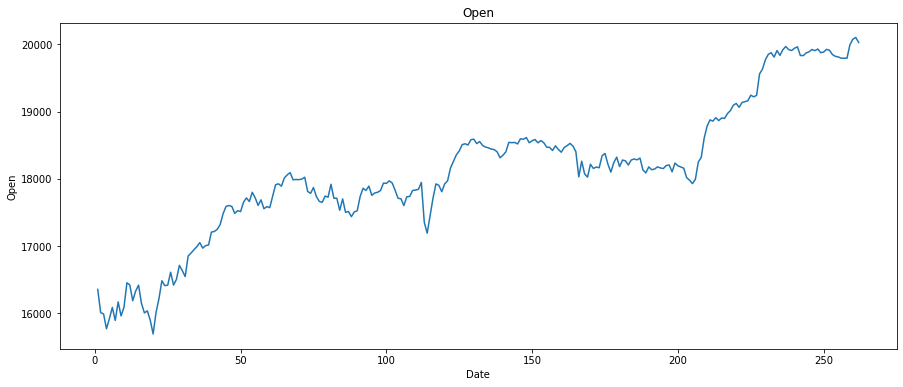

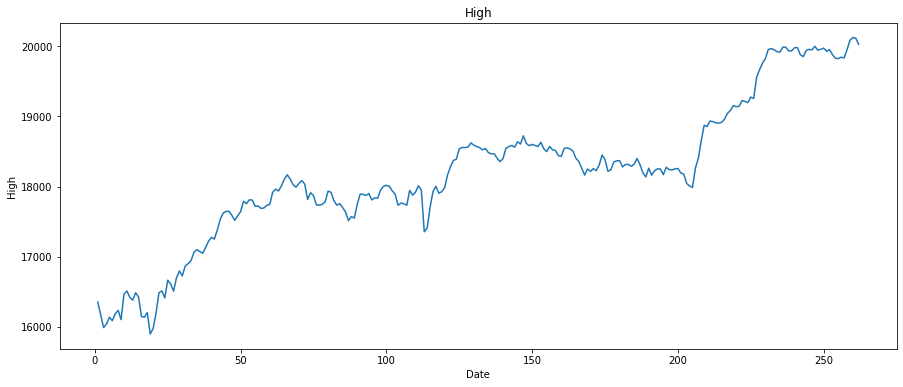

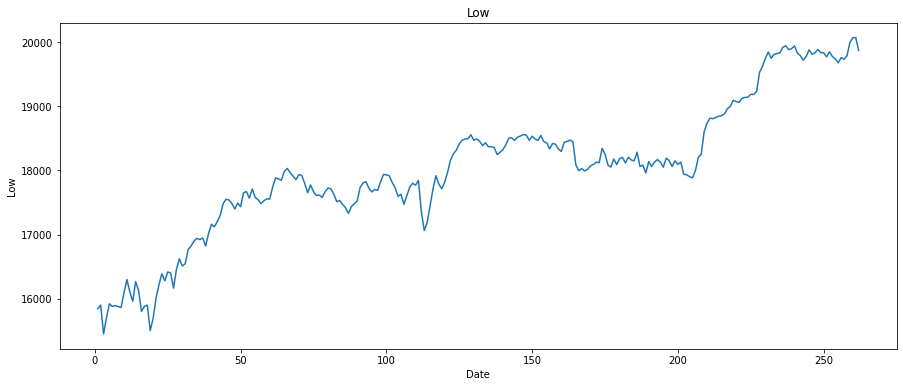

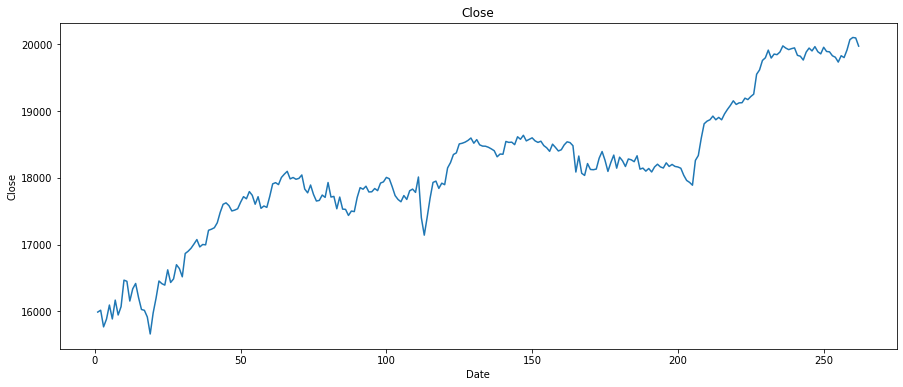

In [ ]:
for c in df[['Open', 'High', 'Low', 'Close']]:
    df[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)}")
    plt.show()

# Histogram:

#### Histogram shows the distribution of data an specific time interval. Each bar shows the value of data in pane.

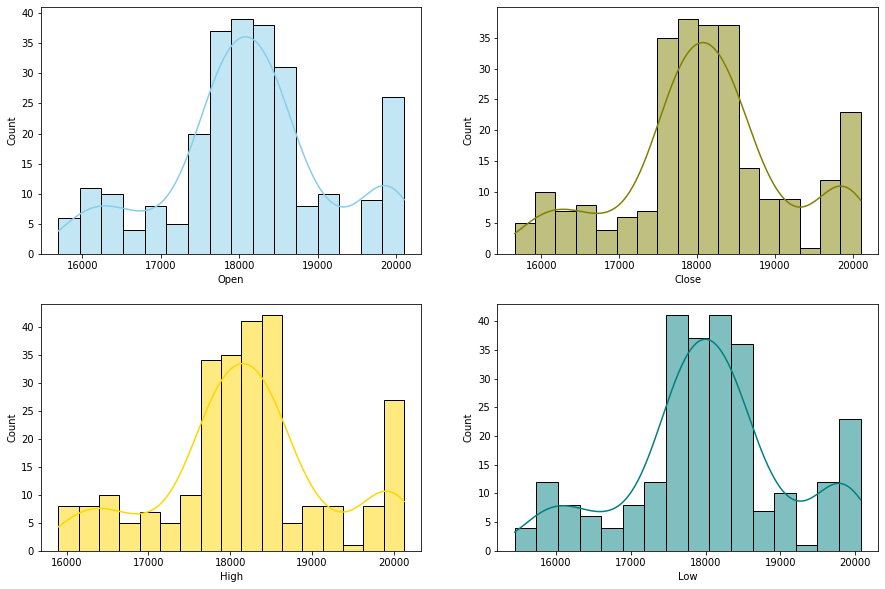

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(data=df, x="Open", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="Close", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="High", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="Low", kde=True, color="teal", ax=axs[1, 1])

plt.show()


## Kernel Density Estimation Plot (KDE):

#### kernel density estimation is a way of estamiting an unknown probability density function given in data.

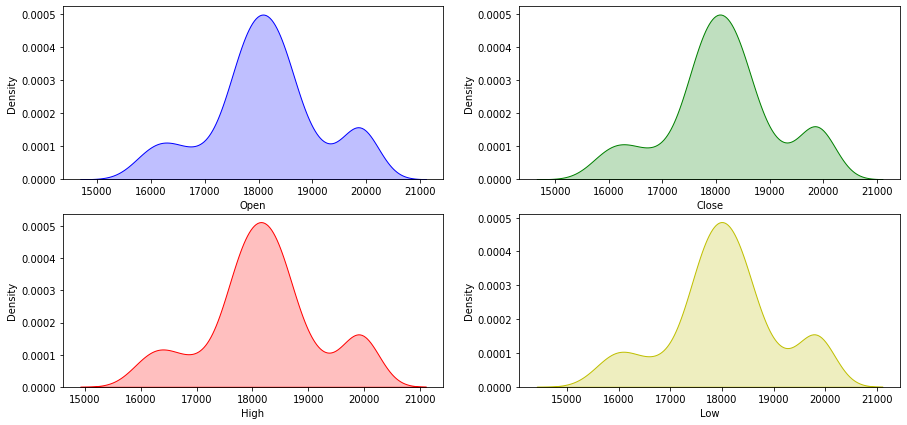

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
p1=sns.kdeplot(df['Open'], shade=True, color="b",ax=axs[0,0])
p2=sns.kdeplot(df['Close'], shade=True, color="g",ax=axs[0,1])
p3=sns.kdeplot(df['High'], shade=True, color="r",ax=axs[1,0])
p4=sns.kdeplot(df['Low'], shade=True, color="y",ax=axs[1,1])
plt.show()

## Time series Evaluation Metrics:

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

# Dickey-Fuller test (ADF) to check data is stationary or not! 

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

## Here we have multiple time series, check for every time series:

In [ ]:
for name, column in df[['Open', 'High', 'Low', 'Close']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                  -0.776223
p-value                          0.826007
No Lags Used                     0.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                  -1.240162
p-value                          0.656085
No Lags Used                     2.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -0.981046
p-value                          0.760114
No L

### As to see above, data is non stationary.

# Spliting the data into train and test:

In [ ]:
X = df[['Open', 'High', 'Low', 'Close' ]]
train, test = X[0:-30], X[-30:]

# Applying the differncing method on time series: 

#### To use this method, made the time series data stationary.

In [ ]:
train_difference = train.diff()
train_difference.dropna(inplace = True)

In [ ]:
for name, column in train_difference[['Open', 'High', 'Low', 'Close' ]].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_difference[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.579687e+01
p-value                        1.085613e-28
No Lags Used                   0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.172782e+01
p-value                        1.364178e-21
No Lags Used                   1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -3.997846
p-value                          0.001422


### As to see above, the time series data, we are using for modelling is stationary.

# Implement cointegration test:

In [ ]:
def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

#### Check the correlation between the time series. To Understand how time series interact with one another will help us create models that are more accurate.

In [ ]:
cointegration_test(train_difference[['Open', 'High', 'Low', 'Close']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  311.57    > 40.1749   =>   True
High   >  201.62    > 24.2761   =>   True
Low    >  102.52    > 12.3212   =>   True
Close  >  32.21     > 4.1296    =>   True


In [ ]:
pq = []
for name, column in train_difference[[ 'Open', 'High', 'Low', 'Close'  ]].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_difference[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2891.139, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2887.158, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2889.136, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2889.135, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2885.680, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2887.514, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2887.501, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2889.092, Time=0.45 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.317 seconds
optimal order for:Open is: (0, 0, 0) 


Searching order of p and q for : High
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2806.440, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2811.486, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2808.164, Time=0.06

# Dictionary of parameters for grid search:
### Parameters in the varma models are (p, q and d).

In [ ]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
pg


[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 1, 'tr': 'c'},
 {'p': 1, 'q': 1, 'tr': 't'},
 {'p': 1, 'q': 1, 'tr': 'ct'},
 {'p': 1, 'q': 2, 'tr': 'n'},
 {'p': 1, 'q': 2, 'tr': 'c'},
 {'p': 1, 'q': 2, 'tr': 't'},
 {'p': 1, 'q': 2, 'tr': 'ct'},
 {'p': 1, 'q': 3, 'tr': 'n'},
 {'p': 1, 'q': 3, 'tr': 'c'},
 {'p': 1, 'q': 3, 'tr': 't'},
 {'p': 1, 'q': 3, 'tr': 'ct'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'c'},
 {'p': 2, 'q': 1, 'tr': 't'},
 {'p': 2, 'q': 1, 'tr': 'ct'},
 {'p': 2, 'q': 2, 'tr': 'n'},
 {'p': 2, 'q': 2, 'tr': 'c'},
 {'p': 2, 'q': 2, 'tr': 't'},
 {'p': 2, 'q': 2, 'tr': 'ct'},
 {'p': 2, 'q': 3, 'tr': 'n'},
 {'p': 2, 'q': 3, 'tr': 'c'},
 {'p': 2, 'q': 3, 'tr': 't'},
 {'p': 2, 'q': 3, 'tr': 'ct'},
 {'p': 3, 'q': 1, 'tr': 'n'},
 {'p': 3, 'q': 1, 'tr': 'c'},
 {'p': 3, 'q': 1, 'tr': 't'},
 {'p': 3, 'q': 1, 'tr': 'ct'},
 {'p': 3, 'q': 2, 'tr': 'n'},
 {'p': 3, 'q': 2, 'tr': 'c'},
 {'p': 3, 'q': 2, 'tr': 't'},
 {'p': 3, 'q': 2, 'tr': 'ct'},
 {'p': 3, 'q': 3, 'tr': 'n'},
 {

## Fit the Model:

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_difference[[ 'Open', 'High', 'Low', 'Close'   ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df[[ 'Open', 'High', 'Low', 'Close'   ]] , result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(test['Open'], inv_res.Open_1st_inv_diff))
        Highrmse = np.sqrt(metrics.mean_squared_error(test['High'], inv_res.High_1st_inv_diff))
        Lowrmse = np.sqrt(metrics.mean_squared_error(test['Low'], inv_res.Low_1st_inv_diff))
        Closermse = np.sqrt(metrics.mean_squared_error(test['Close'], inv_res.Close_1st_inv_diff))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse,'RMSE High':Highrmse,'RMSE Low':Lowrmse,'RMSE Close':Closermse }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (0, 0, 2)
 Running for (0, 0, 2)
 Running for (0, 0, 1)
 Total time taken to complete grid search in seconds: 37.1437381479991


# Print dataframe values in the sorted order of each feature RMSE

In [ ]:
df_results_moni.sort_values(by = ['RMSE Open','RMSE High','RMSE Low','RMSE Close'] )

,p,q,RMSE Open,RMSE High,RMSE Low,RMSE Close
0,0.0,2.0,261.937258,187.739520,287.204221,317.840516
1,0.0,2.0,261.937258,187.739520,287.204221,317.840516
2,0.0,1.0,314.060836,209.752675,336.625108,345.664847


#### In the data frame according to the lowest RMSE, as shown above   parameters is (p = 0, q = 2) because it gives the least RMSE values.

### Fit the Model VARMAX:

In [ ]:
model = VARMAX(train_difference[[ 'Open', 'High', 'Low', 'Close' ]], order=(0,2)).fit( disp=False)
result = model.forecast(steps = 30)

In [ ]:
var_m = inverse_diff(df[['Open', 'High', 'Low', 'Close' ]],result)

In [ ]:
var_m

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-98.000076,-128.246583,-17.130268,-5.590247,19930.619065,19900.372558,19853.260357,19965.540612
232,-14.842427,-37.240117,-2.697406,-7.309380,19915.776638,19863.132441,19850.562951,19958.231233
233,15.361895,15.537780,16.851553,16.495307,19931.138533,19878.670221,19867.414504,19974.726539
234,15.361895,15.537780,16.851553,16.495307,19946.500428,19894.208001,19884.266058,19991.221846
235,15.361895,15.537780,16.851553,16.495307,19961.862323,19909.745782,19901.117611,20007.717152
236,15.361895,15.537780,16.851553,16.495307,19977.224218,19925.283562,19917.969164,20024.212459
237,15.361895,15.537780,16.851553,16.495307,19992.586113,19940.821342,19934.820718,20040.707766
238,15.361895,15.537780,16.851553,16.495307,20007.948008,19956.359122,19951.672271,20057.203072
239,15.361895,15.537780,16.851553,16.495307,20023.309902,19971.896903,19968.523825,20073.698379
240,15.361895,15.537780,16.851553,16.495307,20038.671797,19987.434683,19985.375378,20090.193685


### As shown below, it is the evaluation metrics for every time series in the multivariate time series.

In [ ]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , var_m[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
Evaluation metric results:-
MSE is : 68611.12732869301
MAE is : 222.77716674402183
RMSE is : 261.93725838202744
MAPE is : 1.120407788491005
R2 is : -10.22366416109334

Evaluation metric for High
Evaluation metric results:-
MSE is : 35246.1272572484
MAE is : 150.78288093176573
RMSE is : 187.73951970016435
MAPE is : 0.7567379251151677
R2 is : -5.332939818299558

Evaluation metric for Low
Evaluation metric results:-
MSE is : 82486.26477920833
MAE is : 239.3196109964825
RMSE is : 287.204221381247
MAPE is : 1.2078218605737636
R2 is : -8.659213646838547

Evaluation metric for Close
Evaluation metric results:-
MSE is : 101022.59332160372
MAE is : 281.44332723649654
RMSE is : 317.840515544516
MAPE is : 1.4154845730518415
R2 is : -12.335034814150434



# Plot:

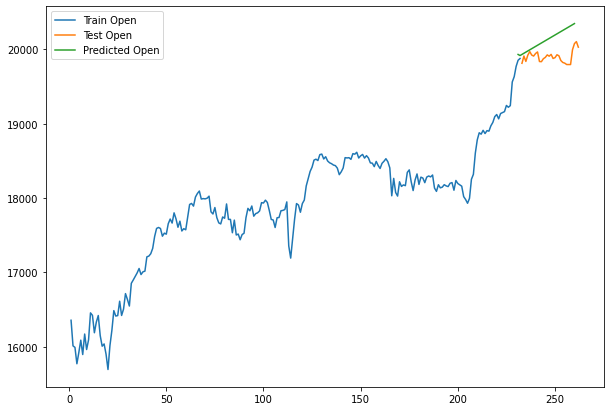

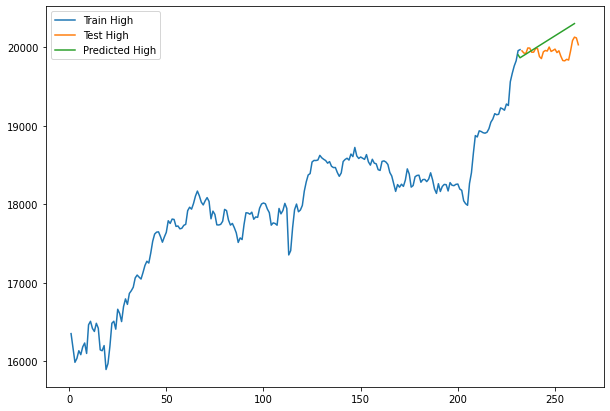

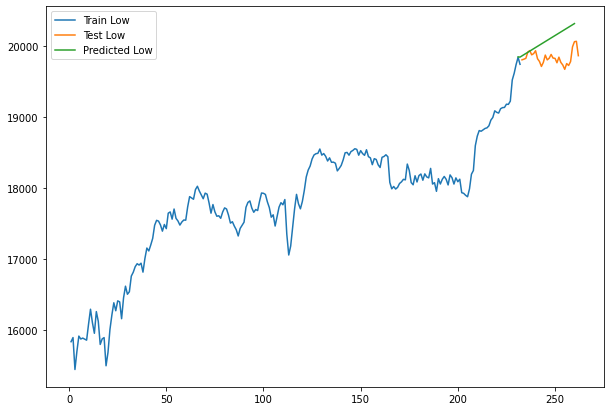

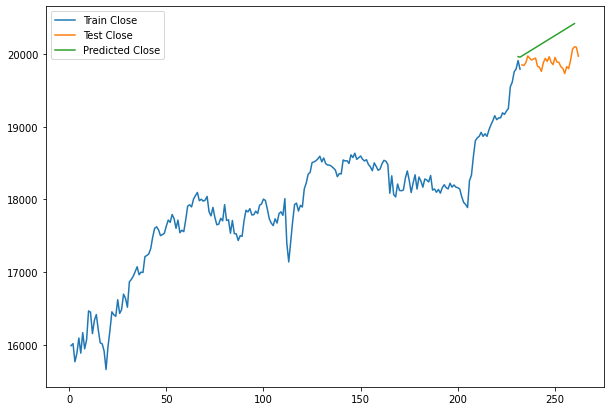

In [ ]:
%matplotlib inline
for i in ['Open', 'High', 'Low', 'Close' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(var_m[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

# Conclustion:

### In order to predict values for multivariate time series without trend and seasonal components, Vector Autoregressive Moving Average model (VARMA) is used. As shown above the future values for some variables in the data dataset namely, 'Open', 'High', 'Low' and 'Close'are predicted. The green line in each graph, represents the predicted values for each variables. This model has an improvment potential using exogenous data in order to achieve better and more precise results. The VARMA model which uses additional exogenous data is called VARMAX.